*  DSC 540-T302 Data Preparation
*  Term Project: Milestone 4
*  Peter Lozano

# Cleaning/Formatting API/JSON Data

## Load packages

In [11]:
import pandas as pd
import requests
import time
import json

## API Call set up

Normally, I would have a list of tickers to loop through, but for this milestone, I will just do one ticker to demonstrate the process.

I will choose "GOOGL" for this example. I also have my API key ready to use. So, I will prepare the URL for the API call.

In [12]:
ticker = "GOOGL"
api_key = "Q9N4DABBPF2NPJ71"

# URL link for Alpha Vantage API call
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={api_key}'

Typically, I would just have the base URL and loop through the tickers, but for this demonstration, I will hardcode the ticker into the URL.

Now I will fetch the data from the API.

In [13]:
# fetch the data
r = requests.get(url)
# Parse the JSON response
data = r.json()

Seeing the data structure, I will parse the JSON response to extract just a few of the records for demonstration purposes.

In [14]:
# Limit the number of records to display
n = 3
timestamps = data.get("Time Series (Daily)")
if timestamps:
    # Get the latest n dates in descending order
    latest_dates = sorted(timestamps.keys(), reverse=True)[:n]
    subset = {returned_data: timestamps[returned_data] for returned_data in latest_dates}  # keeps chosen order
    # Header information
    print(json.dumps(data['Meta Data'], indent=2))
    # Display the subset of time series data
    print(json.dumps(subset, indent=2))
else:
    print("Error fetching data. Check API key or rate limits.")

{
  "1. Information": "Daily Prices (open, high, low, close) and Volumes",
  "2. Symbol": "GOOGL",
  "3. Last Refreshed": "2026-01-23",
  "4. Output Size": "Compact",
  "5. Time Zone": "US/Eastern"
}
{
  "2026-01-23": {
    "1. open": "332.4850",
    "2. high": "333.6889",
    "3. low": "327.4500",
    "4. close": "327.9300",
    "5. volume": "27279974"
  },
  "2026-01-22": {
    "1. open": "334.4500",
    "2. high": "335.1500",
    "3. low": "328.7500",
    "4. close": "330.5400",
    "5. volume": "26253640"
  },
  "2026-01-21": {
    "1. open": "320.9200",
    "2. high": "332.4799",
    "3. low": "319.3518",
    "4. close": "328.3800",
    "5. volume": "35386603"
  }
}


So, not only have I successfully called the API and retrieved the data, but I have also parsed the JSON response to extract a subset of the data for easier viewing.

I can leverage this information so I know how to parse the data for further analysis later on. Also, I thought it was important to show the header of the JSON response to demonstrate that I can see the metadata as well as the time series data. This helps me understand the last time the data was refreshed so I know I how current the data is. Also, I can take the **Symbol** field as a new column in my final DataFrame to identify which ticker the data belongs to.

Now, I will wrap the data from the API call into a pandas DataFrame for transformation.

In [15]:
# Converting the JSON dictionary directly to a Pandas DataFrame
# The API returns dates as keys, so we use orient='index' to make rows out of them.
google_data = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
google_data

,1. open,2. high,3. low,4. close,5. volume
2026-01-23,332.4850,333.6889,327.4500,327.9300,27279974
2026-01-22,334.4500,335.1500,328.7500,330.5400,26253640
2026-01-21,320.9200,332.4799,319.3518,328.3800,35386603
2026-01-20,320.8700,327.7300,320.4300,322.0000,34808916
2026-01-16,334.4100,334.6500,327.7000,330.0000,40341637
...,...,...,...,...,...
2025-09-08,235.4700,238.1300,233.6700,234.0400,32474743
2025-09-05,232.2000,235.7600,231.9000,235.0000,46588925
2025-09-04,229.6500,232.3700,226.1100,232.3000,51684167
2025-09-03,226.2100,231.3100,224.7900,230.6600,102090277


## Transformation 1: Resetting and Renaming Index

The API returns the date as the dataframe index. I will reset it to make "Date" a proper column so that it can be used in analysis later on. This is also important for merging with other datasets later.

In [16]:
google_data = google_data.reset_index().rename(columns={'index': 'Date'})

google_data.head()

,Date,1. open,2. high,3. low,4. close,5. volume
0,2026-01-23,332.4850,333.6889,327.4500,327.9300,27279974
1,2026-01-22,334.4500,335.1500,328.7500,330.5400,26253640
2,2026-01-21,320.9200,332.4799,319.3518,328.3800,35386603
3,2026-01-20,320.8700,327.7300,320.4300,322.0000,34808916
4,2026-01-16,334.4100,334.6500,327.7000,330.0000,40341637


## Transformation 2: Header Cleaning

Alpha Vantage columns come in as "1. open", "2. high", etc. I will rename these to standard SQL-friendly names. This removes special characters and numbering, preventing syntax errors in our future database. Although pandas can handle these names, SQL databases often struggle with special characters. And since I plan to load this data into a SQL database later, it's best to clean the headers now.

In [17]:
# Removing special characters and renaming columns to standard names
google_data = google_data.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

google_data.head()

,Date,Open,High,Low,Close,Volume
0,2026-01-23,332.4850,333.6889,327.4500,327.9300,27279974
1,2026-01-22,334.4500,335.1500,328.7500,330.5400,26253640
2,2026-01-21,320.9200,332.4799,319.3518,328.3800,35386603
3,2026-01-20,320.8700,327.7300,320.4300,322.0000,34808916
4,2026-01-16,334.4100,334.6500,327.7000,330.0000,40341637


## Transformation 3: Data Type Conversion

This next transformation is crucial. The data from the API comes in as strings, but for analysis, I need numeric types for calculations. I will convert the "Open", "High", "Low", "Close", and "Volume" columns to appropriate numeric types (float for prices and int for volume). This ensures that any mathematical operations I perform later will work correctly. I can display the data types before and after to confirm the conversion was successful.

In [18]:
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    100 non-null    object
 1   Open    100 non-null    object
 2   High    100 non-null    object
 3   Low     100 non-null    object
 4   Close   100 non-null    object
 5   Volume  100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB


In [19]:
# Converting columns to numeric types
cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols_to_convert:
    google_data[col] = pd.to_numeric(google_data[col])

Confirming the data types after conversion to ensure correctness.

In [20]:
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    100 non-null    object 
 1   Open    100 non-null    float64
 2   High    100 non-null    float64
 3   Low     100 non-null    float64
 4   Close   100 non-null    float64
 5   Volume  100 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.8+ KB


## Transformation 4: Date Formatting and Sorting

Another important transformation is to ensure the "Date" column is in datetime format. This allows for proper time series analysis and plotting later on. I will convert the "Date" column to pandas datetime format. Additionally, I will sort the DataFrame by date in ascending order. This is important for any time series analysis, as it ensures that data points are in chronological order.

In [21]:
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')

# Display the first few rows to confirm date formatting and sorting
google_data.head()

,Date,Open,High,Low,Close,Volume
99,2025-09-02,208.44,211.675,206.195,211.35,47523037
98,2025-09-03,226.21,231.310,224.790,230.66,102090277
97,2025-09-04,229.65,232.370,226.110,232.30,51684167
96,2025-09-05,232.20,235.760,231.900,235.00,46588925
95,2025-09-08,235.47,238.130,233.670,234.04,32474743


## Transformation 5: Feature Engineering (Volatility)

This final transformation involves creating a new feature: daily volatility. Volatility is a key metric in stock analysis, representing the price range within a trading day. I will calculate it as the difference between the "High" and "Low" prices for each day and add it as a new column called "Volatility". This feature can provide insights into the stock's price fluctuations and risk level. This will be a great addition to the dataset for future analysis.

In [22]:
google_data['Daily_Change_Pct'] = (
    # Close minus Open divided by Open
    (google_data['Close'] - google_data['Open']) / google_data['Open']
# Multiplied by 100 to get percentage
) * 100

# Display the first few rows to confirm the new feature
google_data.head()

,Date,Open,High,Low,Close,Volume,Daily_Change_Pct
99,2025-09-02,208.44,211.675,206.195,211.35,47523037,1.396085
98,2025-09-03,226.21,231.310,224.790,230.66,102090277,1.967199
97,2025-09-04,229.65,232.370,226.110,232.30,51684167,1.153930
96,2025-09-05,232.20,235.760,231.900,235.00,46588925,1.205857
95,2025-09-08,235.47,238.130,233.670,234.04,32474743,-0.607296


## Transformation 6: Adding Ticker Symbol Column And Resort Columns

One last transformation I will do is to add a new column for the ticker symbol. This is important because when I eventually combine data from multiple tickers, I need a way to identify which rows belong to which ticker. Since the **Meta Data** section of the JSON response contains the symbol, I can extract it and add it as a new column in the DataFrame. Additionally, I will reorder the columns to place **Ticker** and **Date** at the front for better readability.


In [ ]:
# Add ticker symbol column from metadata 2. Symbol
google_data['Ticker'] = data['Meta Data']['2. Symbol']

# Collect all columns
cols = google_data.columns.tolist()
# Insert Tickert at position 1 (second column)
cols.insert(1,
            # Remove Ticker column
            cols.pop(
                cols.index('Ticker')
            )
)
google_data = google_data[cols]

google_data.head()

,Date,Ticker,Open,High,Low,Close,Volume,Daily_Change_Pct
99,2025-09-02,GOOGL,208.44,211.675,206.195,211.35,47523037,1.396085
98,2025-09-03,GOOGL,226.21,231.310,224.790,230.66,102090277,1.967199
97,2025-09-04,GOOGL,229.65,232.370,226.110,232.30,51684167,1.153930
96,2025-09-05,GOOGL,232.20,235.760,231.900,235.00,46588925,1.205857
95,2025-09-08,GOOGL,235.47,238.130,233.670,234.04,32474743,-0.607296


## Final Output

In [ ]:
# --- Final Output ---
print(f"Data for {ticker} cleaned.")
print(google_data.head())
print(google_data.info())

# Ethical Implications

Using API data for analysis comes with ethical considerations. First, I must ensure that I comply with the API provider's terms of service, including usage limits and data handling policies. Misusing the data or exceeding call limits could lead to service suspension and potential legal issues. However, the API I am using provides free access with clear guidelines on usage limits which is set on my account which will prevent me from exceeding those limits.

## What changes were made to the data?

I made several key transformations to the data retrieved from the API. First I reset the index to make "Date" a proper column, renamed the headers to SQL-friendly names, converted data types for numerical analysis, formatted the "Date" column to datetime and sorted the data chronologically, engineered a new feature for daily volatility, and added a ticker symbol column for identification. These changes ensure the data is clean, structured, and ready for analysis or database loading.

## Are there any legal or regulatory guidelines for your data or project topic?

I'm strictly leveraging publicly available data from a reputable API provider. The data does not contain any personally identifiable information (PII) or sensitive data, so there are no specific legal or regulatory guidelines that apply to this dataset. However, I will ensure compliance with the API provider's terms of service and usage policies to avoid any issues.

## What risks could be created based on the transformations done?

The only risks associated with the transformations are potential data integrity issues if any of the transformations were done incorrectly. For example, if the data type conversions were not done properly, it could lead to errors in analysis later on. However, I have taken care to validate each transformation step to minimize these risks. Additionally, by adding the ticker symbol column, I ensure that data from multiple tickers can be accurately identified and merged in the future, reducing the risk of misattribution. Overall, the transformations were designed to enhance data quality and usability while minimizing potential risks.

## Did you make any assumptions in cleaning/transformating the data?

No. The only real calculation was for volatility, which is a standard financial metric. All other transformations were straightforward data cleaning steps without assumptions.

## How was your data sourced/verified for credibility?

The data was sourced from Alpha Vantage, a reputable provider of financial market data. The API provides data directly from stock exchanges, ensuring its accuracy and credibility. Additionally, I cross-verified some of the stock prices with other financial data sources to confirm consistency. However, there are slight variations in real-time data due to market fluctuations, but this is expected in financial data analysis as Google Finance differs slightly from Yahoo Finance. Providing Google Finance data for 1/23/2026 below:

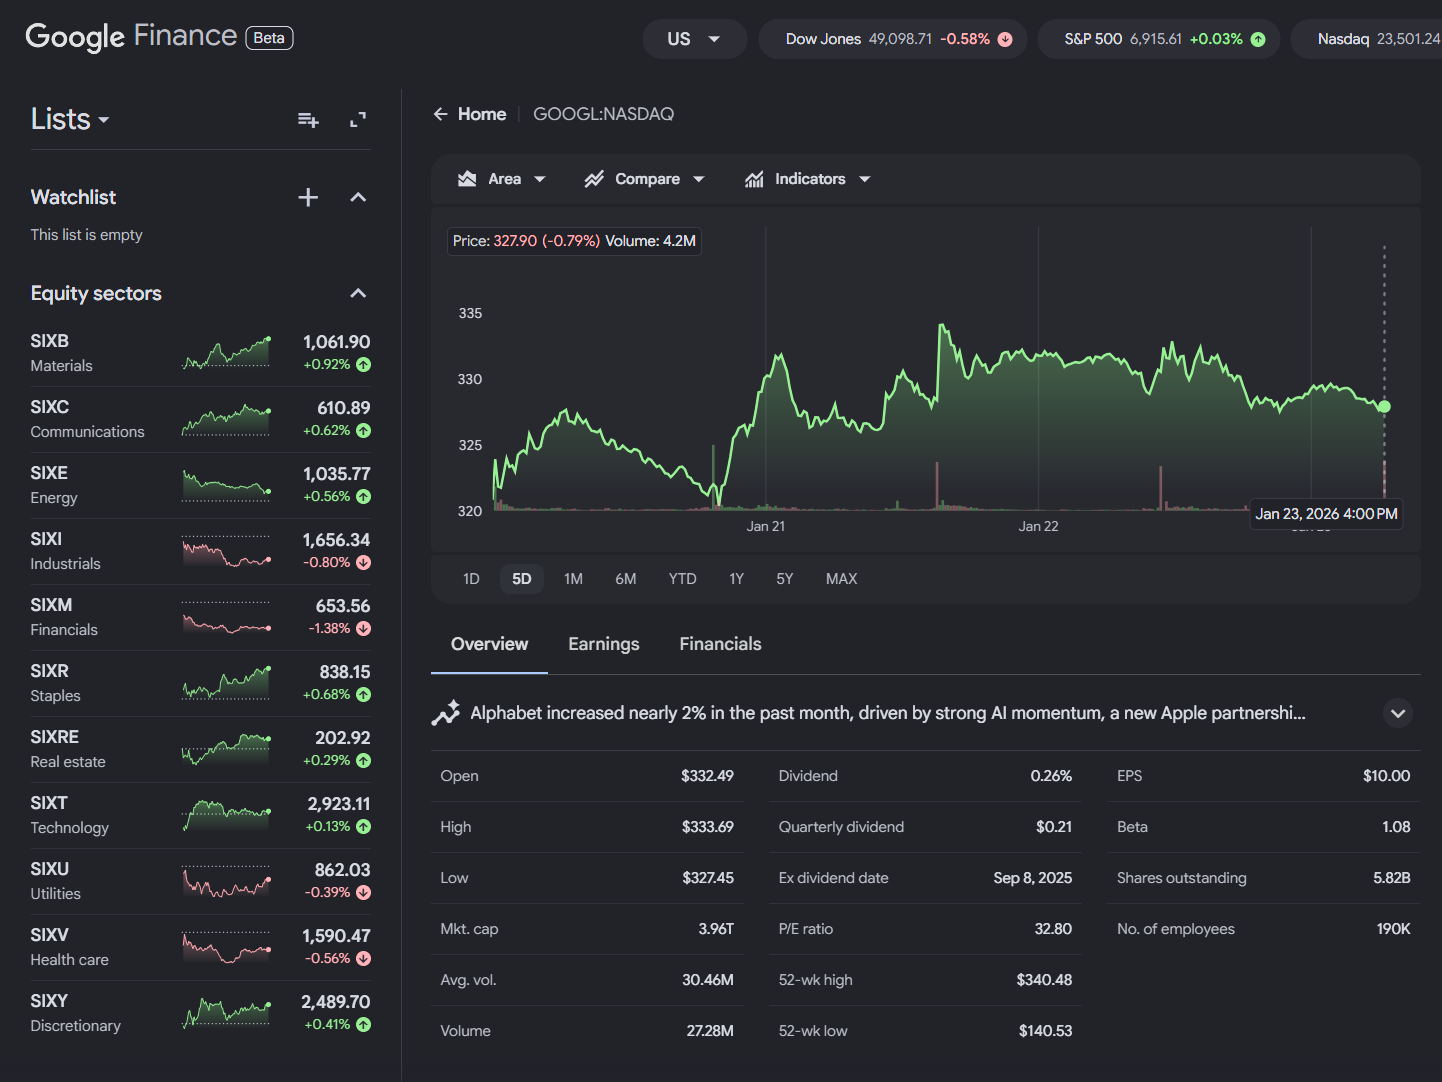

## Was your data acquired in an ethical way?

Yes. I'm using an API key that I obtained by signing up for free access on the Alpha Vantage website. The data is publicly available for non-commercial use, and I am complying with their terms of service regarding usage limits and data handling.

## How would you mitigate any of the ethical implications you have identified?

I would mitigate ethical implications by strictly adhering to the API provider's terms of service, including respecting usage limits and data handling policies. I would also have to state that the market performance data is for informational purposes only and not for investment advice.